<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/time_series/unified_approach/3_Feature_Manipulation_and_Comprehension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Understanding feautures and selecting the most important ones regarding the consumption



---



---



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

import time


df_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/df_resampled.csv"

df = pd.read_csv(df_url)
df['HOSPI_CODE_UCD'] = df['HOSPI_CODE_UCD'].astype('string')
df['ID_SITE_RATTACHE'] = df['ID_SITE_RATTACHE'].astype('string')

medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_SITE_RATTACHE  3276 non-null   string 
 1   HOSPI_CODE_UCD    3276 non-null   string 
 2   MONTH             3276 non-null   int64  
 3   QUANTITY          3276 non-null   float64
 4   N_UFS             3276 non-null   float64
 5   DATE              3276 non-null   object 
 6   N_ETB             3276 non-null   float64
 7   POPULATION        3276 non-null   float64
 8   P_MEDICAL         3276 non-null   float64
 9   PN_MEDICAL        3276 non-null   float64
 10  LIT_HC            3276 non-null   float64
 11  LIT_HP            3276 non-null   float64
 12  SEJ_MCO           3276 non-null   float64
 13  SEJ_HAD           3276 non-null   float64
 14  SEJ_PSY           3276 non-null   float64
 15  SEJ_SSR           3276 non-null   float64
 16  SEJ_SLD           3276 non-null   float64


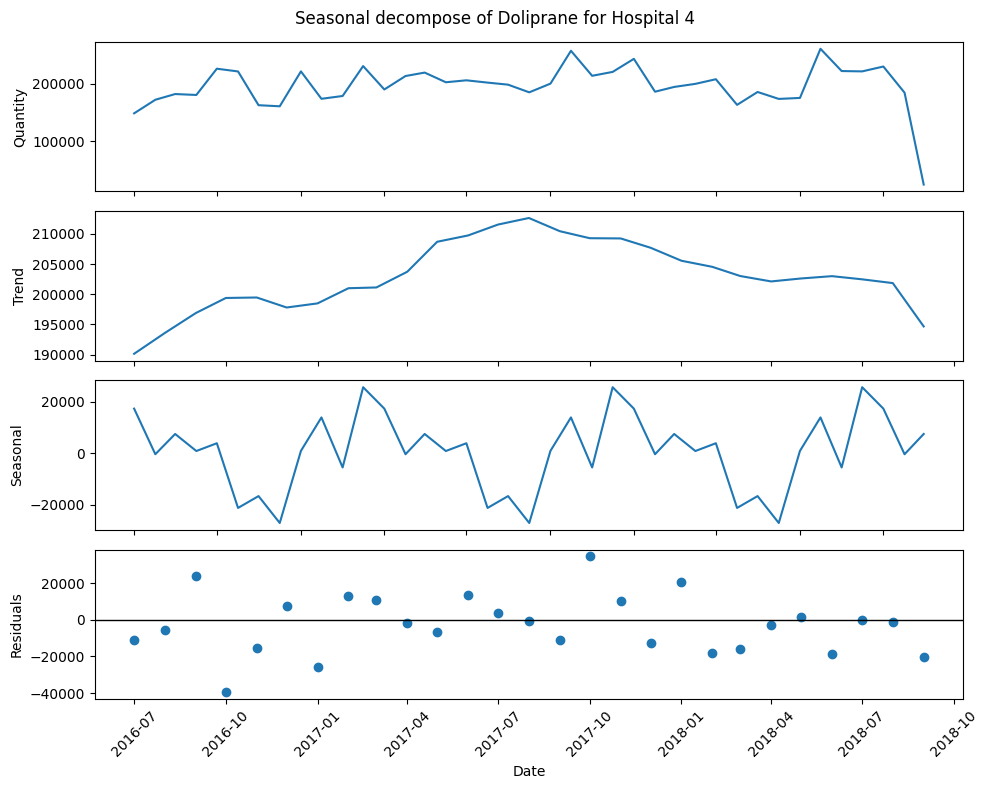

In [51]:
series = df[(df["HOSPI_CODE_UCD"] == '3400891996128') & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["QUANTITY"]
series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == '3400891996128') & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["DATE"])
result = seasonal_decompose(series, model='additive')

# Create a figure and a 4x1 grid of subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
fig.suptitle('Seasonal decompose of Doliprane for Hospital 4')

# Plot on the first subplot (top left)
axes[0].plot(series.index, series.values)
axes[0].set_ylabel('Quantity')
axes[0].tick_params('x', labelbottom=False)

# Plot on the second subplot (top right)
axes[1].plot(result.trend.index, result.trend.values)
axes[1].set_ylabel('Trend')
axes[1].tick_params('x', labelbottom=False)

# Plot on the third subplot (bottom left)
axes[2].plot(result.seasonal.index, result.seasonal.values)
axes[2].set_ylabel('Seasonal')
axes[2].tick_params('x', labelbottom=False)

# Plot on the fourth subplot (bottom right)
axes[3].scatter(result.resid.index, result.resid.values, marker='o')
axes[3].set_ylabel('Residuals')
axes[3].set_xlabel('Date')
axes[3].tick_params('x', labelsize=10, rotation=45)
axes[3].axhline(y=0, linewidth=1, color='black')



# Adjust layout and display the figure

plt.tight_layout()
plt.show()



In [40]:
result.seasonal

DATE
2016-01-01    17388.230903
2016-02-01     -311.769097
2016-03-01     7548.647569
2016-04-01      931.980903
2016-05-01     3952.835069
2016-06-01   -21161.727431
2016-07-01   -16562.102431
2016-08-01   -27003.769097
2016-09-01      987.897569
2016-10-01    13973.647569
2016-11-01    -5446.685764
2016-12-01    25702.814236
2017-01-01    17388.230903
2017-02-01     -311.769097
2017-03-01     7548.647569
2017-04-01      931.980903
2017-05-01     3952.835069
2017-06-01   -21161.727431
2017-07-01   -16562.102431
2017-08-01   -27003.769097
2017-09-01      987.897569
2017-10-01    13973.647569
2017-11-01    -5446.685764
2017-12-01    25702.814236
2018-01-01    17388.230903
2018-02-01     -311.769097
2018-03-01     7548.647569
2018-04-01      931.980903
2018-05-01     3952.835069
2018-06-01   -21161.727431
2018-07-01   -16562.102431
2018-08-01   -27003.769097
2018-09-01      987.897569
2018-10-01    13973.647569
2018-11-01    -5446.685764
2018-12-01    25702.814236
2019-01-01    17388.230

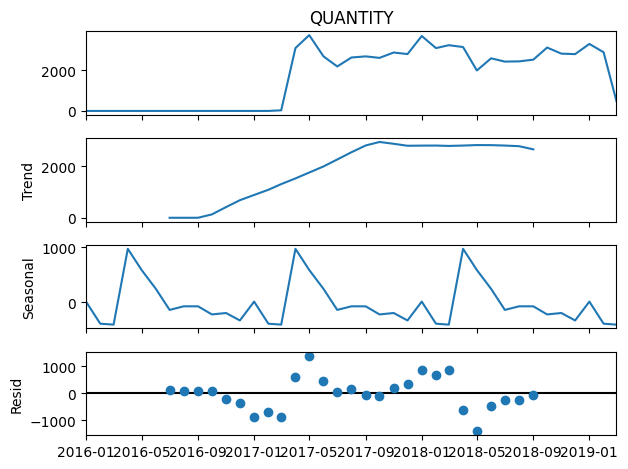

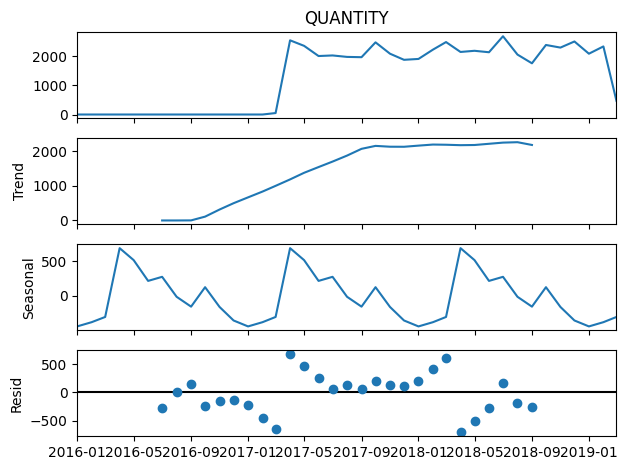

KeyboardInterrupt: ignored

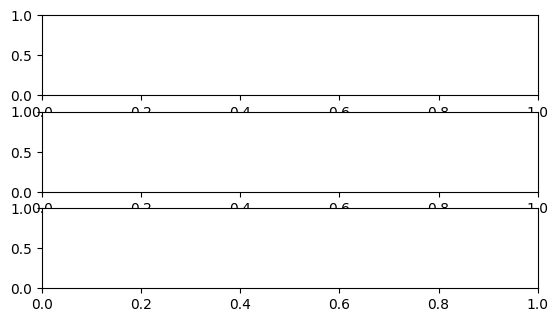

In [42]:
i = 0
for medicine in medicines:
  series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == "HOSPI_2")]["QUANTITY"]
  series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicines[i]) & (df["ID_SITE_RATTACHE"] == "HOSPI_2")]["DATE"])
  result = seasonal_decompose(series, model='additive')
  result.plot()
  plt.show()
  print()
  i += 1

In [ ]:
'''i = 0
for medicine in medicines:
  series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == "HOSPI_3")]["QUANTITY"]
  series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicines[i]) & (df["ID_SITE_RATTACHE"] == "HOSPI_3")]["DATE"])
  result = seasonal_decompose(series, model='additive')
  result.plot()
  plt.show()
  print()
  i += 1'''

'i = 0\nfor medicine in medicines:\n  series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == "HOSPI_3")]["QUANTITY"]\n  series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicines[i]) & (df["ID_SITE_RATTACHE"] == "HOSPI_3")]["DATE"])\n  result = seasonal_decompose(series, model=\'additive\')\n  result.plot()\n  plt.show()\n  print()\n  i += 1'

In [ ]:
'''i = 0
for medicine in medicines:
  series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["QUANTITY"]
  series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicines[i]) & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["DATE"])
  result = seasonal_decompose(series, model='additive')
  result.plot()
  plt.show()
  print()
  i += 1'''

'i = 0\nfor medicine in medicines:\n  series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["QUANTITY"]\n  series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicines[i]) & (df["ID_SITE_RATTACHE"] == "HOSPI_4")]["DATE"])\n  result = seasonal_decompose(series, model=\'additive\')\n  result.plot()\n  plt.show()\n  print()\n  i += 1'

In [ ]:
def ts_features(df):
    for hospital in df.ID_SITE_RATTACHE.unique():
        for medicine in medicines:
            series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["QUANTITY"]
            series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["DATE"])
            result = seasonal_decompose(series, model='additive')
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "TREND"] = result.trend.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "SEASONAL"] = result.seasonal.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "RESID"] = result.resid.values
    df.fillna(0, inplace=True)  # Replace NaN values with zero

In [ ]:
ts_features(df)

In [ ]:
import matplotlib.dates as mdates

def plot_trend_over_time(df, medicines, column):
    for medicine in medicines:
        fig, ax = plt.subplots(figsize=(12, 6))
        for hospital in df.ID_SITE_RATTACHE.unique():
            subset = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]
            x = pd.to_datetime(subset["DATE"])
            y = subset[column]
            ax.plot(x, y, label=hospital)

        ax.set_xlabel('Date')
        ax.set_ylabel(column)
        ax.set_title(f'{column} over time for Medicine {medicine}')
        ax.legend()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
        print()


In [ ]:
'''plot_trend_over_time(df, medicines, "TREND")'''

'plot_trend_over_time(df, medicines, "TREND")'

In [ ]:
'''plot_trend_over_time(df, medicines, "SEASONAL")'''

'plot_trend_over_time(df, medicines, "SEASONAL")'

In [ ]:
'''plot_trend_over_time(df, medicines, "RESID")'''

'plot_trend_over_time(df, medicines, "RESID")'

In [ ]:
df = df[df['QUANTITY'] > 0]
df

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,MONTH,QUANTITY,N_UFS,DATE,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD,TREND,SEASONAL,RESID
0,HOSPI_1,3400890837149,1,1300.0,2.0,2016-01,12.0,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0,0.0,-185.806713,0.0
2,HOSPI_3,3400890837149,1,4080.0,7.0,2016-01,50.0,1132481.0,1290.0,7336.0,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0,0.0,272.505787,0.0
3,HOSPI_4,3400890837149,1,16300.0,1.0,2016-01,39.0,1835903.0,2526.0,15604.0,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0,0.0,-3829.571759,0.0
4,HOSPI_1,3400891191226,1,3076.0,7.0,2016-01,12.0,572744.0,683.0,5273.0,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0,0.0,213.102431,0.0
6,HOSPI_3,3400891191226,1,4670.0,8.0,2016-01,50.0,1132481.0,1290.0,7336.0,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0,0.0,270.371528,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,HOSPI_4,3400893826706,3,1150.0,1.0,2019-03,39.0,1871364.0,2639.0,15774.0,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0,0.0,76.047454,0.0
3272,HOSPI_1,3400893875490,3,764.0,1.0,2019-03,12.0,569894.0,843.0,5438.0,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0,0.0,-95.354167,0.0
3273,HOSPI_2,3400893875490,3,1330.0,5.0,2019-03,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0,0.0,-1751.783565,0.0
3274,HOSPI_3,3400893875490,3,2245.0,21.0,2019-03,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0,0.0,1026.112269,0.0


In [ ]:
common_period = None
minimal_period = 1000

for hospital in ['HOSPI_1', 'HOSPI_2', 'HOSPI_3', 'HOSPI_4']:
    for medicine in medicines:
        ts = df[(df['HOSPI_CODE_UCD'] == medicine) &
                     (df['QUANTITY'] > 0) &
                     (df['ID_SITE_RATTACHE'] == hospital)][['DATE']].copy()
        ts['DATE'] = pd.to_datetime(ts['DATE'])
        if len(ts) > 30:
          if common_period is None:
              common_period = ts
          else:
              common_period = common_period.merge(ts, on='DATE', how='inner')
start_date=common_period['DATE'].min()
end_date=common_period['DATE'].max()


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

df['DATE'] = df['DATE'].copy().apply(pd.to_datetime)

df_common_period = df.copy()
df_common_period = df_common_period.loc[(df_common_period['DATE'] >= start_date) & (df_common_period['DATE'] <= end_date)]
df_common_period = df_common_period.reset_index()
df_common_period

,index,ID_SITE_RATTACHE,HOSPI_CODE_UCD,MONTH,QUANTITY,N_UFS,DATE,N_ETB,POPULATION,P_MEDICAL,...,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD,TREND,SEASONAL,RESID
0,0,HOSPI_1,3400890837149,1,1300.0,2.0,2016-01-01,12.0,572744.0,683.0,...,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0,0.0,-185.806713,0.0
1,2,HOSPI_3,3400890837149,1,4080.0,7.0,2016-01-01,50.0,1132481.0,1290.0,...,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0,0.0,272.505787,0.0
2,3,HOSPI_4,3400890837149,1,16300.0,1.0,2016-01-01,39.0,1835903.0,2526.0,...,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0,0.0,-3829.571759,0.0
3,4,HOSPI_1,3400891191226,1,3076.0,7.0,2016-01-01,12.0,572744.0,683.0,...,1388.0,105.0,78311.0,0.0,0.0,1177.0,51.0,0.0,213.102431,0.0
4,6,HOSPI_3,3400891191226,1,4670.0,8.0,2016-01-01,50.0,1132481.0,1290.0,...,2030.0,506.0,120193.0,787.0,2755.0,1309.0,88.0,0.0,270.371528,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,3187,HOSPI_4,3400893826706,2,6450.0,1.0,2019-02-01,39.0,1871364.0,2639.0,...,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0,0.0,-277.077546,0.0
2602,3188,HOSPI_1,3400893875490,2,8399.0,13.5,2019-02-01,12.0,569894.0,843.0,...,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0,0.0,-287.687500,0.0
2603,3189,HOSPI_2,3400893875490,2,8838.0,15.5,2019-02-01,5.0,542302.0,706.0,...,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0,0.0,-1514.096065,0.0
2604,3190,HOSPI_3,3400893875490,2,12865.0,16.0,2019-02-01,50.0,1171739.0,1318.0,...,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0,0.0,-1022.741898,0.0


In [ ]:
df_common_period.to_csv('df_common_period.csv', index=False)